# 1-4 时间序列建模流程规范
利用RNN预测新冠疫情

In [1]:
import os
import importlib
import torchkeras

## 一、准备数据
本文的数据集取自tushare

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 [Text(-10.0, 0, '2020-03-01'),
  Text(0.0, 0, '2020-01-24'),
  Text(10.0, 0, '2020-02-03'),
  Text(20.0, 0, '2020-02-13'),
  Text(30.0, 0, '2020-02-23'),
  Text(40.0, 0, '2020-03-04'),
  Text(50.0, 0, '')])

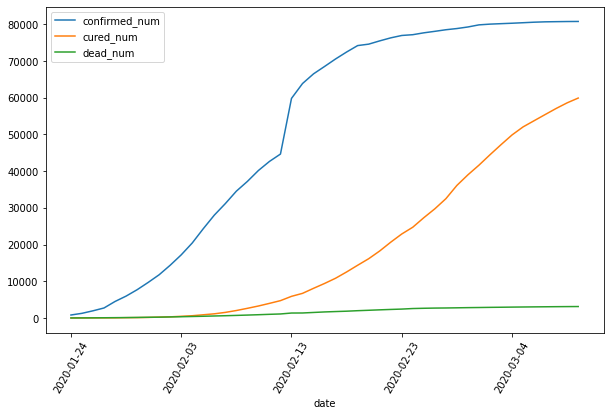

In [3]:
# 展示数据
df = pd.read_csv("./data/covid-19.csv", sep="\t")
df.plot(x="date", y=["confirmed_num", "cured_num", "dead_num"], figsize=(10, 6))
plt.xticks(rotation=60)

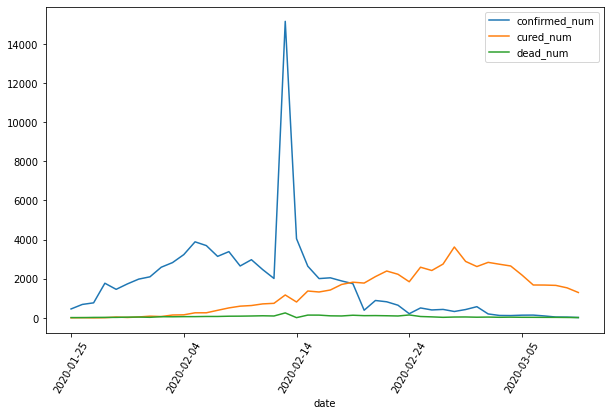

In [4]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")


dfdiff.plot(x="date", y=["confirmed_num", "cured_num", "dead_num"], figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date", axis=1).astype("float32")

In [5]:
dfdiff.head()

,confirmed_num,cured_num,dead_num
0,457.0,4.0,16.0
1,688.0,11.0,15.0
2,769.0,2.0,24.0
3,1771.0,9.0,26.0
4,1459.0,43.0,26.0


In [6]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [7]:
# 使用某日前8天窗口数据作为输入预测该日期
WINDOW_SIZE = 8

class Covid19Dataset(Dataset):

    def __len__(self):
        return len(dfdiff) - WINDOW_SIZE

    def __getitem__(self, i):
        x = dfdiff.loc[i:i+WINDOW_SIZE-1, :]
        feature = torch.tensor(x.values)
        y = dfdiff.loc[i+WINDOW_SIZE, :]
        label = torch.tensor(y.values)
        return (feature, label)

ds_train = Covid19Dataset()

# 数据较小, 可以将全部数据放入batch中
dl_train = DataLoader(ds_train, batch_size=38)

## 二、定义模型
使用Pytorch通常有第三种方式构建模型, 这里不再赘述。此处选择第二种方式构建模型。

In [8]:
import torch
from torch import nn

torch.random.seed()

class Block(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, x, x_input):
        x_out = torch.max((1+x)*x_input[:,-1:], torch.tensor(0.0))
        return x_out

class Net(nn.Module):

    def __init__(self):
        super().__init__()
        # 三层lstm
        self.lstm = nn.LSTM(input_size=3, hidden_size=3, num_layers=5, batch_first=True)
        self.linear = nn.Linear(3, 3)
        self.block = Block()

    def forward(self, x_input):
        x = self.lstm(x_input)[0][:, -1, :]
        x = self.linear(x)
        y = self.block(x, x_input)
        return y

net = Net()
model = torchkeras.Model(net)
model.summary(input_shape=(8, 3), input_dtype=torch.FloatTensor)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              LSTM-1                 [-1, 8, 3]             480
            Linear-2                    [-1, 3]              12
             Block-3                 [-1, 2, 3]               0
Total params: 492
Trainable params: 492
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000092
Forward/backward pass size (MB): 0.000252
Params size (MB): 0.001877
Estimated Total Size (MB): 0.002220
----------------------------------------------------------------


## 三、训练模型

In [9]:
def mspe(y_pred, y_true):
    err_percent = (y_true - y_pred)**2 / (torch.max(y_true**2, torch.tensor(1e-7)))
    return torch.mean(err_percent)

model.compile(loss_func=mspe, optimizer=torch.optim.Adagrad(model.parameters(), lr=0.1))

In [10]:
dfhistory = model.fit(100, dl_train, log_step_freq=10)

Start Training ...

================================================================================2020-09-16 11:51:47

 +-------+---------+
| epoch |   loss  |
+-------+---------+
|   1   | 717.505 |
+-------+---------+

================================================================================2020-09-16 11:51:47

 +-------+---------+
| epoch |   loss  |
+-------+---------+
|   2   | 486.408 |
+-------+---------+

================================================================================2020-09-16 11:51:47

 +-------+---------+
| epoch |   loss  |
+-------+---------+
|   3   | 356.658 |
+-------+---------+

================================================================================2020-09-16 11:51:47

 +-------+---------+
| epoch |   loss  |
+-------+---------+
|   4   | 199.012 |
+-------+---------+

================================================================================2020-09-16 11:51:47

 +-------+--------+
| epoch |  loss  |
+-------+--------+
|   5   |

## 四、评估模型
评估模型一般要设置验证集或者测试集, 由于此比例数据集较少, 我们仅仅可视化模型在训练集上面的迭代情况。

In [11]:
import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, "bo--")
    plt.title("Training" + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()

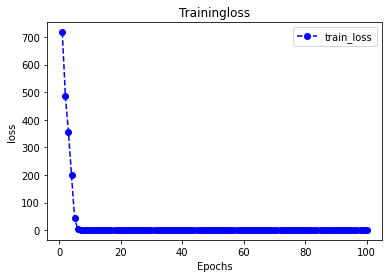

In [12]:
plot_metric(dfhistory,"loss")

## 五、使用模型
预测新增为0的时间

In [14]:
# 用dfresult记录现有数据以及伺候预测的疫情数据
dfresult = dfdiff[["confirmed_num", "cured_num", "dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [28]:
# 预测此后200天的趋势
for i in range(200):
    arr_input = torch.unsqueeze(torch.from_numpy(dfresult.values[-38:, :]), axis=0)
    arr_predict = model.forward(arr_input)
    arr_predict = torch.squeeze(arr_predict, dim=0)
    dfpredict = pd.DataFrame(torch.floor(arr_predict).data.numpy(), columns=dfresult.columns)
    dfresult = dfresult.append(dfpredict, ignore_index=True)

In [31]:
dfresult.query("confirmed_num==0").head()

,confirmed_num,cured_num,dead_num
15246,0.0,91.0,4.0
15247,-0.0,6.0,1.0
15248,0.0,0.0,0.0
15249,-0.0,0.0,0.0
15250,0.0,0.0,0.0
